# Development notebook for rewriting data generation process fresh, without heavy reliance on sympy methods

In [1]:
import numpy as np
import scipy.integrate as integ
import sympy as sym

In [2]:
def relax_kelvin(E_mods, viscs):
    
    E_mods_1plus_array = np.array(E_mods[1:]).reshape(-1,1)
    viscs_array = np.array(viscs).reshape(-1,1)
    
    taus = viscs/E_mods_1plus_array
    
    relax_kelvin_lambda = lambda t: E_mods[0] + np.sum(E_mods_1plus_array*np.exp(-t/taus))
    
    return relax_kelvin_lambda

In [3]:
def creep_kelvin(E_mods, viscs):
    
    E_mods_1plus_array = np.array(E_mods[1:]).reshape(-1,1)
    viscs_array = np.array(viscs).reshape(-1,1)
    
    taus = viscs/E_mods_1plus_array
    
    creep_kelvin_lambda = lambda t: 1/E_mods[0] + np.sum((1-np.exp(-t/taus))/E_mods_1plus_array)
    
    return creep_kelvin_lambda

In [4]:
def relax_creep_kelvin(E_mods, viscs, input_type):
    
    E_mods_1plus_array = np.array(E_mods[1:]).reshape(-1,1)
    viscs_array = np.array(viscs).reshape(-1,1)
    
    taus = viscs/E_mods_1plus_array
    
    if input_type == 'Strain':
        relax_creep_lambda = lambda t: E_mods[0] + np.sum(E_mods_1plus_array*np.exp(-t/taus))
    elif input_type == 'Stress':
        relax_creep_lambda = lambda t: 1/E_mods[0] + np.sum((1-np.exp(-t/taus))/E_mods_1plus_array)
    else:
        print('Incorrect input_type')
        relax_creep_lambda = False
    
    return relax_creep_lambda

In [9]:
def calculate_strain_stress(input_type, time_array, input_expr, E_mods, viscs, D_input_lambda=None):
    
    if D_input_lambda:
        input_lambda = input_expr
    else:
        t = sym.symbols('t', real=True)
        D_input_expr = input_expr.diff(t)
        
        input_lambda = sym.lambdify(t, input_expr)
        D_input_lambda = sym.lambdify(t, D_input_expr)
    
    relax_creep_lambda = relax_creep_kelvin(E_mods, viscs, input_type)
    
    integrand_lambda = lambda x, t: relax_creep_lambda(t-x)*D_input_lambda(x)
    integral_lambda = lambda t: integ.quad(integrand_lambda, 0, t, args=(t))[0]
    
    output_array = np.array([])
    input_array = np.array([])
    for time_point in time_array:
        first_term = input_lambda(0)*relax_creep_lambda(time_point)
        second_term = integral_lambda(time_point)
        output_array = np.append(output_array, first_term + second_term)
        input_array = np.append(input_array, input_lambda(time_point))
    
    if input_type == 'Strain':
        strain_array = input_array
        stress_array = output_array
    else:
        strain_array = output_array
        stress_array = input_array
        
    strain_array = strain_array.reshape(time_array.shape)
    stress_array = stress_array.reshape(time_array.shape)
    
    return strain_array, stress_array

In [10]:
'''
def calculate_strain_stress(input_type, time_array, input_lambda, D_input_lambda, E_mods, viscs):
    
    
    if input_type == 'Strain':
        relax_creep_lambda = relax_kelvin(E_mods, viscs)
    elif input_type = 'Stress':
        relax_creep_lambda = creep_kelvin(E_mods, viscs)
    else:
        print('Incorrect input_type')
    
    integrand_lambda = lambda x, t: relax_creep_lambda(t-x)*D_input_lambda(x)
    integral_lambda = lambda t: integ.quad(integrand_lambda, 0, t, args=(t))
    
    first_term = input_lambda(time_array)*relax_creep_lambda(time_array)
    second_term = integral_lambda(time_array)
    
    output = first_term + second_term
    
    return output
'''

"\ndef calculate_strain_stress(input_type, time_array, input_lambda, D_input_lambda, E_mods, viscs):\n    \n    \n    if input_type == 'Strain':\n        relax_creep_lambda = relax_kelvin(E_mods, viscs)\n    elif input_type = 'Stress':\n        relax_creep_lambda = creep_kelvin(E_mods, viscs)\n    else:\n        print('Incorrect input_type')\n    \n    integrand_lambda = lambda x, t: relax_creep_lambda(t-x)*D_input_lambda(x)\n    integral_lambda = lambda t: integ.quad(integrand_lambda, 0, t, args=(t))\n    \n    first_term = input_lambda(time_array)*relax_creep_lambda(time_array)\n    second_term = integral_lambda(time_array)\n    \n    output = first_term + second_term\n    \n    return output\n"

In [11]:
E = [1,10,1]
eta = [20,20]
t = sym.symbols('t', real=True)
strain_expr = sym.sin(t)
input_type = 'Strain'
time_array = np.linspace(0.001, 30, 5000)

In [12]:
strain_array, stress_array = calculate_strain_stress(input_type, time_array, strain_expr, E, eta)

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

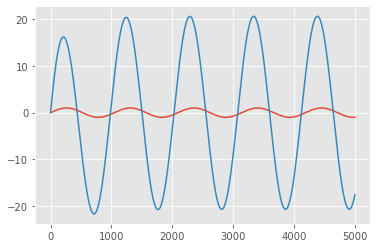

In [15]:
plt.plot(strain_array)
plt.plot(stress_array)